UI to work with SBI stuff

In [1]:
import os
import subprocess
import logging
import sys

def source_lmod_script(script_path):
    """
    Source an Lmod/module script and import environment variables into Python safely,
    suppressing terminal warnings.
    """
    # Use a non-interactive login shell (bash -l), redirect errors
    command = f'bash -l -c "source {script_path} >/dev/null 2>&1; printenv -0"'
    
    proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
    out, _ = proc.communicate()
    
    # Parse null-separated environment variables
    for env_var in out.split(b'\0'):
        if env_var:
            key, _, value = env_var.partition(b'=')
            os.environ[key.decode()] = value.decode()

# Example usage
M3_BUILD_DIR = "/home/henryi/scratch/venvs/.venv_sbi/bin/"
TUTORIAL_BUILD_DIR = M3_BUILD_DIR
source_lmod_script(f"{M3_BUILD_DIR}/setup.MaCh3.sh")
source_lmod_script(f"{TUTORIAL_BUILD_DIR}/setup.MaCh3Tutorial.sh")
os.environ["OMP_NUM_THREADS"] = "8"


my_stderr = sys.stderr = open('errors.txt', 'w')  # redirect stderr to file
get_ipython().log.handlers[0].stream = my_stderr  # log errors to new stderr
get_ipython().log.setLevel(logging.INFO)  # errors are logged at info level

cat: write error: Broken pipe
cat: write error: Broken pipe


In [2]:
from mach3sbitools.ui.sbi_ui import MaCh3SbiUI
from mach3sbitools.utils.device_handler import TorchDeviceHander
from mach3sbitools.diagnostics.diagnostics import SBIDiagnostics

from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import numpy as np

Couldn't find DUNE instance
Found MaCh3 Tutorial instance, using that!
FOUND


In [3]:
input_file = Path("/home/henryi/sft/MaCh3Tutorial/TutorialConfigs/FitterConfig.yaml")
ui = MaCh3SbiUI(str(input_file), 'tutorial')
device_handler = TorchDeviceHander()

Trying to open /home/henryi/sft/MaCh3Tutorial/TutorialConfigs/FitterConfig.yaml with tutorial
Opening files with Tutorial!
[Monitor.cpp][info] ##################################
[Monitor.cpp][info] Welcome to:  
[Monitor.cpp][info]   __  __        _____ _     ____  
[Monitor.cpp][info]  |  \/  |      / ____| |   |___ \ 
[Monitor.cpp][info]  | \  / | __ _| |    | |__   __) |
[Monitor.cpp][info]  | |\/| |/ _` | |    | '_ \ |__ < 
[Monitor.cpp][info]  | |  | | (_| | |____| | | |___) |
[Monitor.cpp][info]  |_|  |_|\__,_|\_____|_| |_|____/ 
[Monitor.cpp][info] Version: 2.3.1
[Monitor.cpp][info] ##################################
[Monitor.cpp][info] Using following CPU:
[Monitor.cpp][info] model name	: AMD EPYC 9454 48-Core Processor
[Monitor.cpp][info] cpu MHz		: 3799.442
[Monitor.cpp][info] Architecture:                         x86_64
[Monitor.cpp][info] L1d cache:                            1.5 MiB (48 instances)
[Monitor.cpp][info] L1i cache:                            1.5 MiB (48 instan

In [4]:
# Fit settings!
FIT_TYPE='mechanistic_embedding'
N_ROUNDS = 5
PRIOR_SAMPLES = 100_000
SAMPLES_PER_ROUND = 200_000

In [5]:
# Now we can run the fit!
ui.initialise_fitter(FIT_TYPE, N_ROUNDS, PRIOR_SAMPLES, SAMPLES_PER_ROUND)

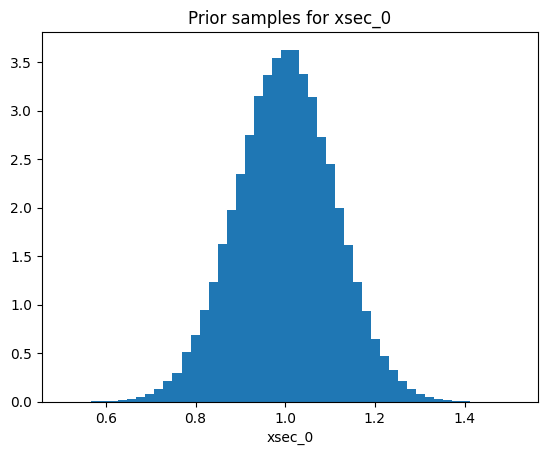

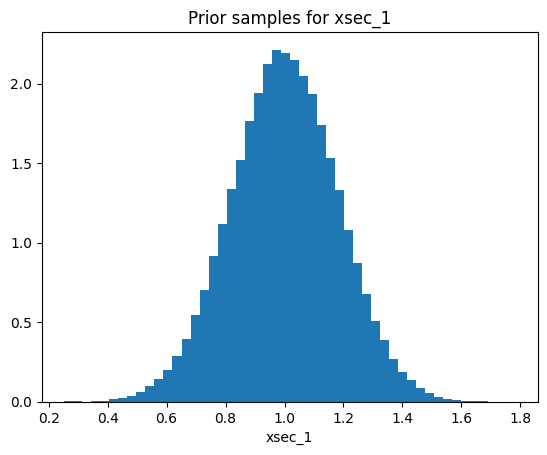

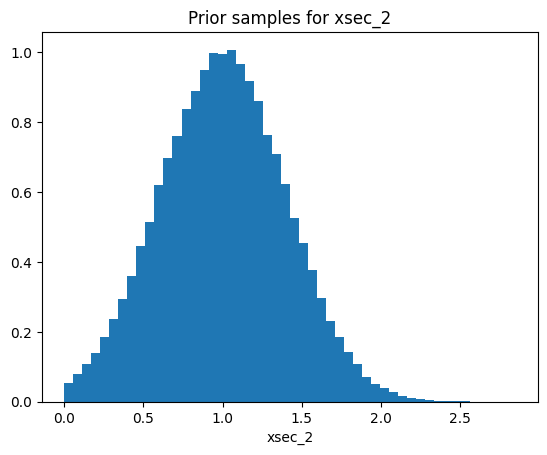

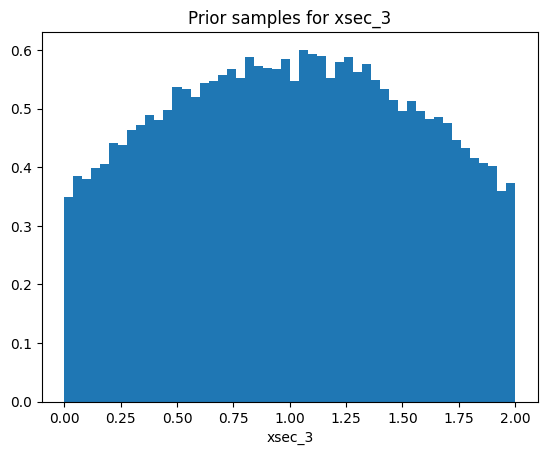

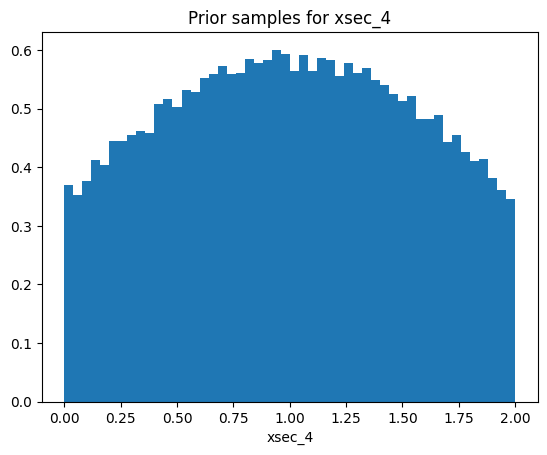

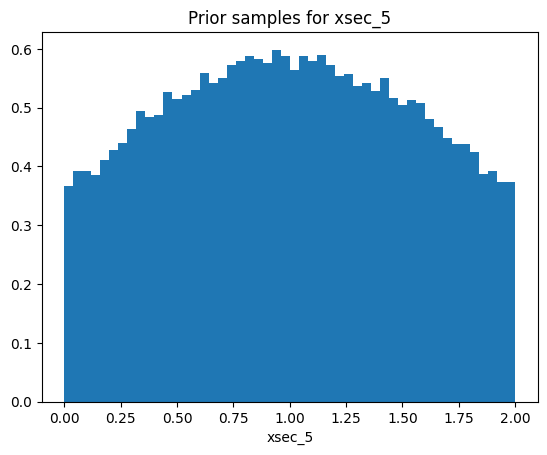

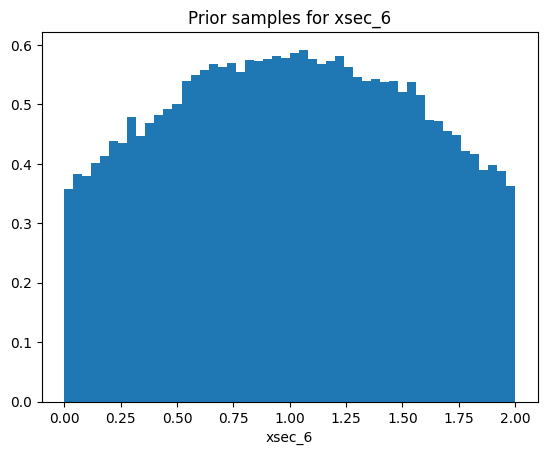

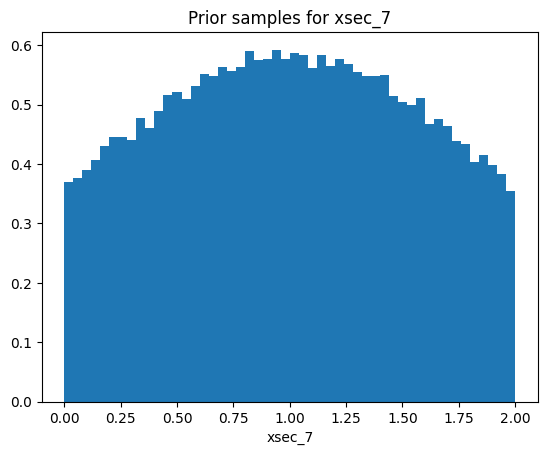

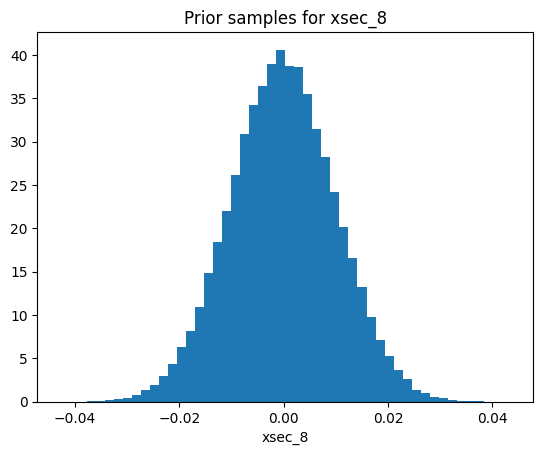

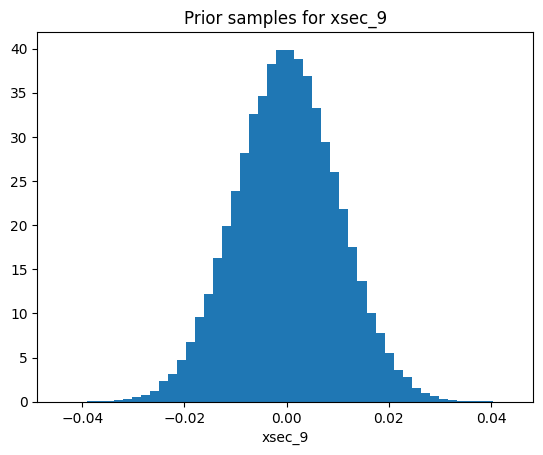

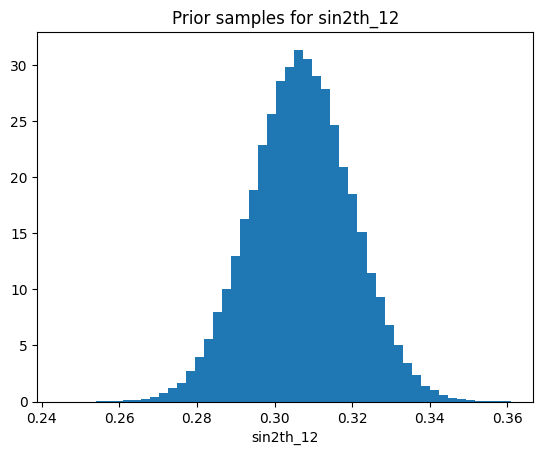

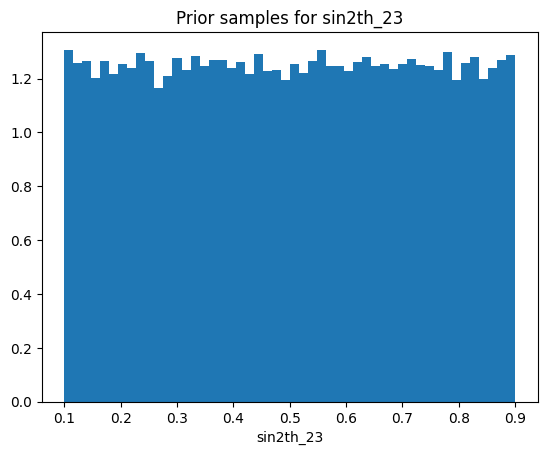

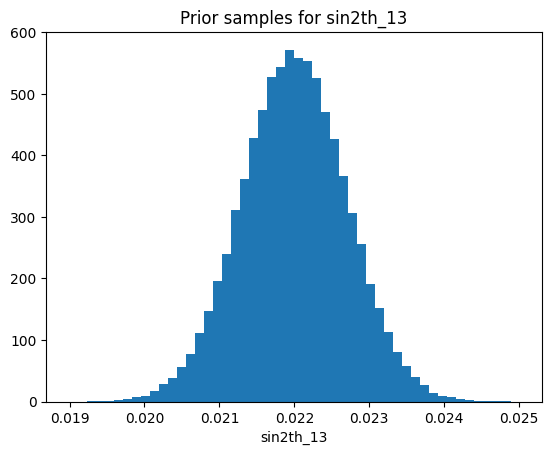

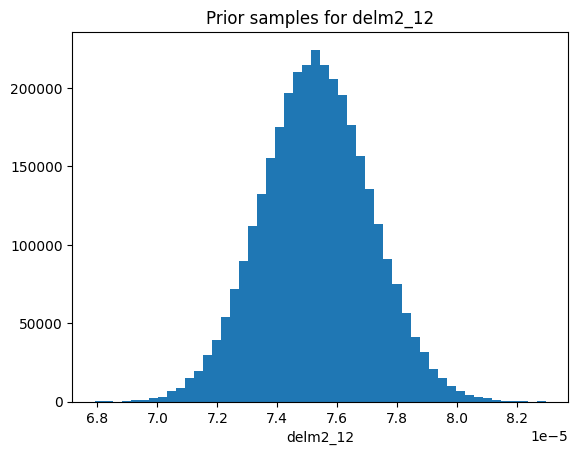

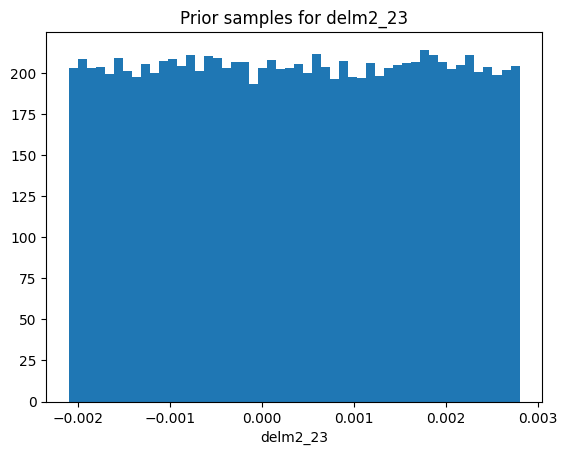

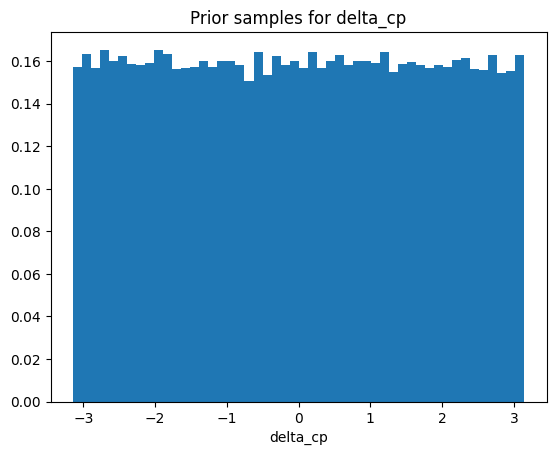

In [6]:
# Prior check
prior_samples = ui.fitter.prior.sample((100000,))
for i, lab in enumerate(ui.mach3.get_parameter_names()):
    plt.hist(prior_samples[:, i].cpu(), bins=50, density=True)
    plt.xlabel(lab)
    plt.title(f"Prior samples for {lab}")
    plt.show()

In [7]:
ui.train()

Using scaling method: none


  0%|          | 0/5 [00:00<?, ?it/s]

Getting MC Spectra from MaCh3:   0%|          | 0/100000 [00:00<?, ?it/s]

 Neural network successfully converged after 224 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 224
        Best validation performance: -53.9200
        -------------------------
        


  0%|          | 0/200000 [00:00<?, ?it/s]

Getting MC Spectra from MaCh3:   0%|          | 0/200000 [00:00<?, ?it/s]

 Neural network successfully converged after 102 epochs.
        -------------------------
        ||||| ROUND 2 STATS |||||:
        -------------------------
        Epochs trained: 102
        Best validation performance: -0.2751
        -------------------------
        


  0%|          | 0/200000 [00:00<?, ?it/s]

Getting MC Spectra from MaCh3:   0%|          | 0/200000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:
ui.fitter.save(Path('my_fit_2_stage_300kT.pkl'))

Saving to my_fit_2_stage_300kT.pkl


In [ ]:
import uproot as ur
import pickle

# with open('/home/henryi/sft/MaCh3SbiTools/notebooks/my_fit.pkl', 'rb') as handle:
#     saved_posterior = pickle.load(handle)

# s_saved = saved_posterior['posterior'].sample((100000,), x=ui.fitter.x0, show_progress_bars=True)

s = ui.fitter.sample(10_000_000, x=ui.fitter.x0, show_progress_bars=True) #, max_sampling_batch_size=1, oversampling_factor=2)

tree = ur.open("/home/henryi/sft/MaCh3Tutorial/Test.root:posteriors")

# s = saved_posterior.sample((100000,), device_handler.to_tensor(ui.fitter.x0))

arrs = tree.arrays(library="np")

  0%|          | 0/10000000 [00:00<?, ?it/s]

In [12]:
s_refined = ui.fitter.sample_refined(50_000,  x=ui.fitter.x0, oversampling_factor=16)

Refining posterior with Poisson likelihood...


Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/160000 [00:00<?, ?it/s]

Getting MC Spectra from MaCh3:   0%|          | 0/160000 [00:00<?, ?it/s]

  0%|          | 0/160000 [00:00<?, ?it/s]

Getting MC Spectra from MaCh3:   0%|          | 0/160000 [00:00<?, ?it/s]

  0%|          | 0/160000 [00:00<?, ?it/s]

Getting MC Spectra from MaCh3:   0%|          | 0/160000 [00:00<?, ?it/s]

  0%|          | 0/160000 [00:00<?, ?it/s]

Getting MC Spectra from MaCh3:   0%|          | 0/160000 [00:00<?, ?it/s]

  0%|          | 0/160000 [00:00<?, ?it/s]

Getting MC Spectra from MaCh3:   0%|          | 0/160000 [00:00<?, ?it/s]

In [ ]:
for i, name in enumerate(ui.mach3.get_parameter_names()):

    ml_sample = s[:, i]
    # saved_sample = s_saved[:, i]
    ml_sample_refined = s_refined[:, i]
    tree_sample = arrs[name][100000:]

    if name == "delm2_23":
        fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

        for ax, cut_label, cut_fn in [
            (axes[0], "IO", lambda x: x < 0),
            (axes[1], "NO", lambda x: x > 0),
        ]:
            # apply cuts independently
            ml_cut = ml_sample[cut_fn(ml_sample)]
            # saved_cut = saved_sample[cut_fn(saved_sample)]
            refined_cut = ml_sample_refined[cut_fn(ml_sample_refined)]
            tree_cut = tree_sample[cut_fn(tree_sample)]

            # bins defined from ML sample only
            _, bins = np.histogram(ml_cut.cpu(), bins=100, density=True)

            ax.hist(tree_cut, bins=bins, density=True,
                    histtype="step", linewidth=2, label="MCMC", color="k")
            ax.hist(ml_cut.cpu(), bins=bins, density=True,
                    histtype="step", linewidth=2, label="ML")
            ax.hist(refined_cut.cpu(), bins=bins, density=True,
                    histtype="step", linewidth=2,
                    label="ML, Refined", linestyle="--")

            ax.set_xlabel(f"{name} ({cut_label})")
            ax.set_ylabel("Density")
            ax.legend(loc='upper left', fontsize='x-small')

        plt.tight_layout()
        plt.show()
        continue

    # ---- default path ----
    _, bins = np.histogram(ml_sample.cpu(), bins=100, density=True)

    plt.hist(tree_sample, bins=bins, density=True,
             histtype="step", linewidth=2, label="MCMC", color="k")
    plt.hist(ml_sample.cpu(), bins=bins, density=True,
             histtype="step", linewidth=2, label="ML")
    plt.hist(ml_sample_refined.cpu(), bins=bins, density=True,
             histtype="step", linewidth=2,
             label="ML, Refined", linestyle="--")

    plt.legend(loc='upper left', fontsize='x-small')
    plt.xlabel(name)
    plt.ylabel("Density")
    plt.show()


In [ ]:
# Dumb stuff
from sbi.analysis.plot import sbc_rank_plot
from sbi.diagnostics import check_sbc, check_tarp, run_sbc, run_tarp


num_posterior_samples = 1000
num_sbc_samples = 100  # choose a number of sbc runs, should be ~100s


thetas = ui.fitter.prior.sample(num_sbc_samples)
xs, thetas = ui.fitter.get_x_vals(thetas)


ranks, dap_samples = run_sbc(
    thetas,
    xs,
    ui.fitter.posterior,
    num_posterior_samples=num_posterior_samples,
    num_workers=8,
    use_sample_batched=True,  # True can give a speed-up, but might cause memory issues.
)



In [ ]:
check_stats = check_sbc(
    ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples
)

print(
    f"""kolmogorov-smirnov p-values \n
    check_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"""
)

print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)

print(f"- c2st accuracies check_stats['c2st_dap'] = {check_stats['c2st_dap'].numpy()}")




In [ ]:
_ = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    parameter_labels=ui.mach3.get_parameter_names(),
    plot_type="hist",
    num_bins=None,  # by passing None we use a heuristic for the number of bins.
)


In [ ]:
sbc_rank_plot(ranks, 1_000, plot_type="cdf", parameter_labels=ui.mach3.get_parameter_names())

In [ ]:
# We now check the posterior predictive
for name in parameter_names:
    tree_sample = arrs[name][100000:]  # Apply your burn-in cut
    tree_samples_list.append(tree_sample)

# Stack into a 2D array: shape (n_steps, n_params)
tree_samples = np.column_stack(tree_samples_list)
